# Explore DSC output

This tutorial is a continuation of the [Quick Start](Quick_Start.html). As a reminder here is the DSC script we've executed:

```yaml
  simulate:
      exec: rnorm.R, rt.R
      seed: R(1:10)
      params:
          n: 1000
          true_mean: 0, 1
      return: x, true_mean

  estimate:
      exec: mean.R, median.R
      params:
          x: $x
      return: mean

  mse:
      exec: MSE.R
      params:
          mean_est: $mean
          true_mean: $true_mean
      return: mse

  DSC:
      run: simulate *
           estimate *
           mse
      exec_path: R/scenarios, R/methods, R/scores
      output: dsc_result
```

To explore the result from this benchmark, we first **annotate** the benchmark with customized *tags*, then we **extract** results for these tags of interest, and finally load it to external anlaysis tools (eg. `R`) to interpret the results.

## DSC annotation

Suppose we are interested in comparing `mean` method vs. `median` method for data generated under *t* distribution with mean equals zero. We thus create two tags, `mean_t` and `median_t` and save them in a text file called `settings.ann`:

```yaml
mean_t:
    simulate: 
        exec: rt.R
        true_mean: 0
    estimate:
        exec: mean.R

median_t:
    simulate: 
        exec: rt.R
        true_mean: 0
    estimate:
        exec: median.R

DSC:
    configuration: settings.dsc
```

We then apply the annotation with the `dsc` command:

In [1]:
! dsc -a settings.ann

INFO: 
+----------------+--------------------------------------------------+
|  Tag           |  No. unique obj.                                 |
+----------------+--------------------------------------------------+
|  mean_t    |  10 estimate & 10 mse & 10 simulate  |
|  median_t  |  10 estimate & 10 mse & 10 simulate  |
+----------------+--------------------------------------------------+
INFO: Elapsed time 0.053 seconds.


Now the annotation has been applied. A summary of the annotation executed is also displayed on the terminal.

## DSC data extraction
The ultimate result of the DSC benchmark is the `mse` variable and we want to compare the performance of the two scenarios that we have just tagged using the `mse` variable. We will extract these tags to a separate data file using the `dsc` command:

In [2]:
! dsc -e mse:mse -b dsc_result

Extracting: 100%|██████████| 3/3 [00:00<00:00, 10.93it/s]
INFO: Data extracted to dsc_result.mse.rds for all annotations for DSC result mse.
INFO: Elapsed time 0.594 seconds.


The resulting `dsc_result.mse.rds` file contains the information of interest, which we are going to examine next.

## Analyzing DSC results
We load `dsc_result.mse.rds` to `R` and generate plots to compare the two scenarios we are interested in:

In [3]:
%use ir
dat = readRDS('dsc_result.mse.rds')
dat

$mean_t_mse_mse
$mean_t_mse_mse[[1]]
[1] 0.001998464

$mean_t_mse_mse[[2]]
[1] 0.000375967

$mean_t_mse_mse[[3]]
[1] 0.02536375

$mean_t_mse_mse[[4]]
[1] 0.04809152

$mean_t_mse_mse[[5]]
[1] 4.684348e-05

$mean_t_mse_mse[[6]]
[1] 0.0006672099

$mean_t_mse_mse[[7]]
[1] 0.02075989

$mean_t_mse_mse[[8]]
[1] 0.01496248

$mean_t_mse_mse[[9]]
[1] 0.0002222952

$mean_t_mse_mse[[10]]
[1] 0.004872964


$median_t_mse_mse
$median_t_mse_mse[[1]]
[1] 0.001597311

$median_t_mse_mse[[2]]
[1] 0.00198952

$median_t_mse_mse[[3]]
[1] 0.01041488

$median_t_mse_mse[[4]]
[1] 0.004039523

$median_t_mse_mse[[5]]
[1] 0.001189672

$median_t_mse_mse[[6]]
[1] 0.0003547146

$median_t_mse_mse[[7]]
[1] 0.001267905

$median_t_mse_mse[[8]]
[1] 4.003382e-06

$median_t_mse_mse[[9]]
[1] 2.883096e-05

$median_t_mse_mse[[10]]
[1] 0.0004690183

In [4]:
dat$mean_t = unlist(dat$mean_t_mse_mse)
mean(dat$mean_t)

[1] 0.01173614

In [5]:
dat$median_t = unlist(dat$median_t_mse_mse)
mean(dat$median_t)

[1] 0.002135538

We see the mean MSE is smaller for median based method. Now we graphically examine the results:

In [6]:
dat = cbind(c(dat$mean_t, dat$median_t), c(rep('mean', length(dat$mean_t)), rep('median', length(dat$median_t))))
colnames(dat) = c('MSE', 'Method')
dat = data.frame(dat)
dat$MSE <- as.numeric(as.character(dat$MSE))
dat

MSE,Method
1.998464e-03,mean
3.759670e-04,mean
2.536375e-02,mean
4.809152e-02,mean
4.684348e-05,mean
6.672099e-04,mean
2.075989e-02,mean
1.496248e-02,mean
2.222952e-04,mean
4.872964e-03,mean


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


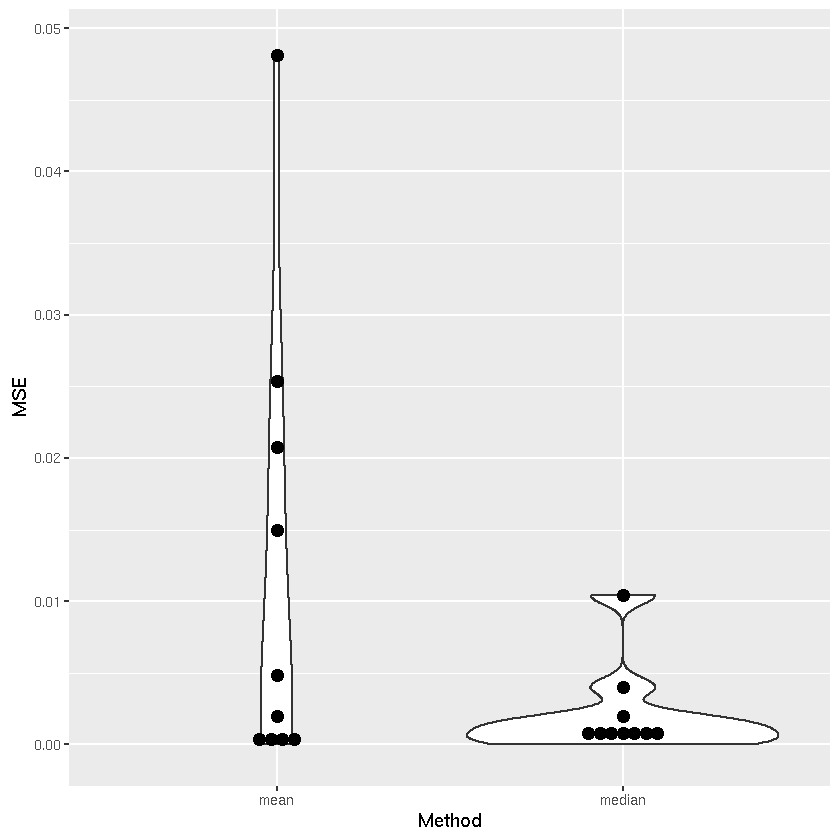

In [7]:
library(ggplot2)
p <- ggplot(data.frame(dat), aes(x=Method, y=MSE)) + 
    geom_violin() +
    geom_dotplot(binaxis='y', stackdir='center', dotsize = .5)
p

## Automatic annotation
For this very simple application, particularly when the value of `true_mean` does not matter for location parameter estimate, one should take advantage of automatic annotation DSC provides to create a tag for every executable. To activate automatic annotation, simply create an empty annotation file with only the DSC configuration file name specified:

```
DSC:
    configuration: settings.dsc
```
and execute it:

In [1]:
! dsc -a settings_auto.ann

INFO: Annotation summary for sequence ending with mse
+--------------+--------------------------------------------------+
|  Tag         |  No. unique obj.                                 |
+--------------+--------------------------------------------------+
|  rnorm   |  20 estimate & 20 mse & 10 simulate  |
|  rt      |  20 estimate & 20 mse & 10 simulate  |
|  mean    |  20 estimate & 20 mse & 20 simulate  |
|  median  |  20 estimate & 20 mse & 20 simulate  |
|  MSE     |  40 estimate & 40 mse & 20 simulate  |
+--------------+--------------------------------------------------+
INFO: Elapsed time 0.076 seconds.


In order to extract results for, for example samples from $t$ distribution using method `mean`, one can overlay the tags `rt` and `mean` to extract the MSE on this sequence. Multiple tag combinations is also allowed. Here we extract 4 cases:
* Case 1: simulated from `rt` and analyzed by `mean`
* Case 2: simulated from `rnorm` and analyzed by `mean`
* Case 3: simulated from `rt` and analyzed by `median`
* Case 4: simulated from `rnorm` and analyzed by `median`

In [2]:
! dsc -e mse:mse -b dsc_result --tags \
    "case1 = rt&&mean" "case2 = rnorm&&mean" \
    "case3 = rt&&median" "case4 = rnorm&&median"

Extracting: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]
INFO: Data extracted to dsc_result.mse.rds for DSC result mse via annotations: 
	case1 = rt&&mean
	case2 = rnorm&&mean
	case3 = rt&&median
	case4 = rnorm&&median
INFO: Elapsed time 0.656 seconds.


The `mean_t` and `median_t` tags in the previous section is equivalent to `case1` and `case3` in this automatic annotation.